# 野村BPI総合 分布

In [38]:
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')
import yfinance as yf

In [39]:
# 野村BPI総合の価格データを取得
nomura_bpi = yf.download('2510.T', start='2014-11-29', end='2024-11-29')
nomura_bpi['log_adj_close'] = np.log(nomura_bpi['Adj Close'])
nomura_bpi['log_adj_close_diff'] = nomura_bpi['log_adj_close'].diff()
# データの先頭を表示
nomura_bpi.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,log_adj_close,log_adj_close_diff
Ticker,2510.T,2510.T,2510.T,2510.T,2510.T,2510.T,,
Date,,,,,,,,
2017-12-06,966.182129,1000.000000,1000.000000,1000.000000,1000.000000,0,6.873352,NaN
2017-12-07,960.964661,994.599976,994.599976,994.599976,994.599976,0,6.867938,-0.005415
2017-12-08,961.698975,995.359985,995.359985,995.359985,995.359985,0,6.868701,0.000764
2017-12-11,971.012939,1005.000000,1006.000000,1000.000000,1006.000000,3560,6.878340,0.009638
2017-12-12,966.182129,1000.000000,1003.000000,999.000000,1003.000000,3580,6.873352,-0.004987


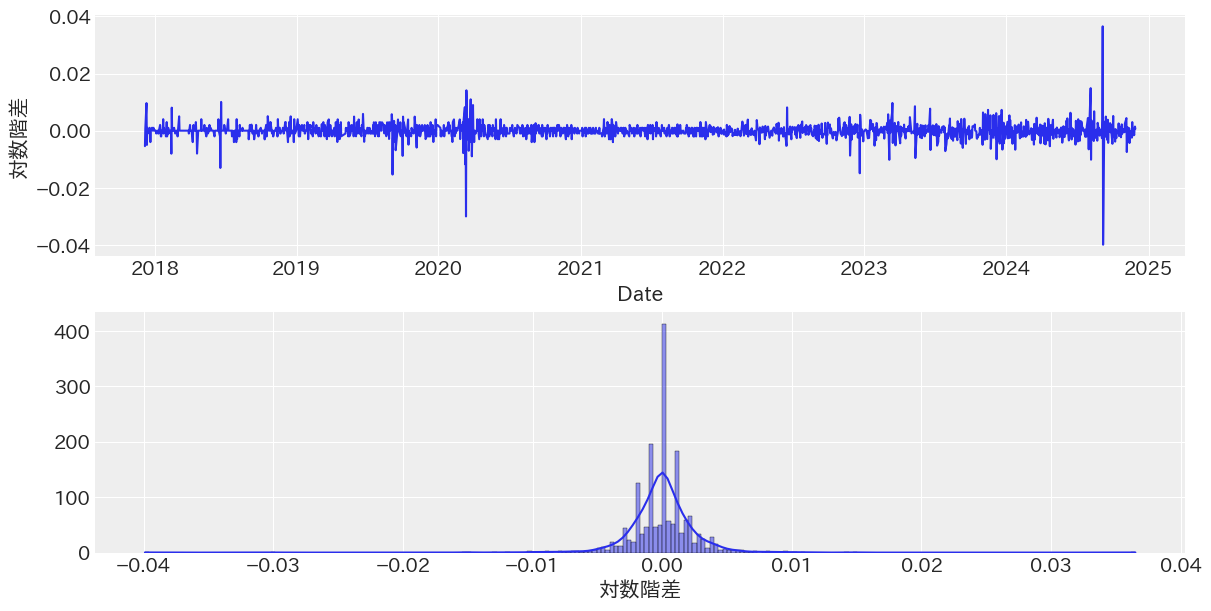

In [40]:
plt.figure(figsize=(12, 6))

plt.subplot(211)
sns.lineplot(x=nomura_bpi.index, y='log_adj_close_diff', data=nomura_bpi)
plt.ylabel('対数階差')

plt.subplot(212)
sns.histplot(nomura_bpi['log_adj_close_diff'], kde=True)
plt.ylabel('')
plt.xlabel('対数階差')

plt.show()

## 正規分布

In [13]:
with pm.Model() as nomura_bpi_normal:
    # data
    y = pm.Data('y', nomura_bpi['log_adj_close_diff'].dropna())

    # prior
    mu = pm.Normal('mu', mu=0, sigma=0.01)
    sigma = pm.HalfNormal('sigma', sigma=0.01)

    # likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # sampling
    trace_normal = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        nuts_sampler='numpyro'
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [14]:
az.summary(trace_normal)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.000,0.0,-0.000,0.000,0.0,0.0,3983.0,3087.0,1.0
sigma,0.003,0.0,0.003,0.003,0.0,0.0,471.0,354.0,1.0


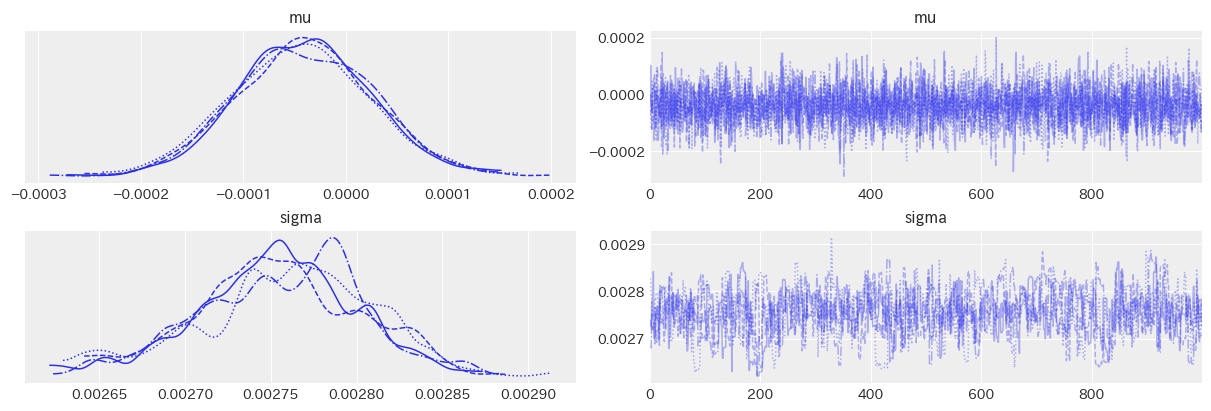

In [15]:
az.plot_trace(trace_normal);

In [16]:
with nomura_bpi_normal:
    pm.sample_posterior_predictive(trace_normal, extend_inferencedata=True)

Sampling: [y_obs]


Output()

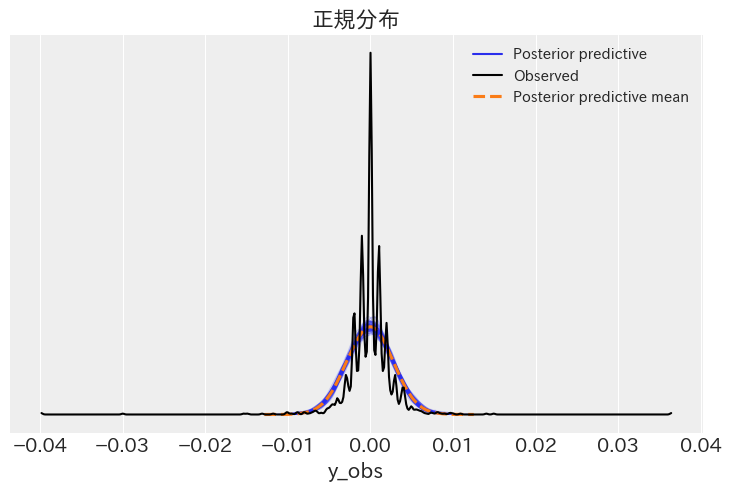

In [17]:
az.plot_ppc(trace_normal, num_pp_samples=100)
plt.title('正規分布')
plt.show()

In [18]:
annualized_return = trace_normal.posterior['mu'].values.flatten().mean() * 365.25
annualized_volatility = trace_normal.posterior['sigma'].values.flatten().mean() * np.sqrt(365.25)
print(f'年率リターン: {annualized_return:.2%}')
print(f'年率ボラティリティ: {annualized_volatility:.2%}')

年率リターン: -1.51%
年率ボラティリティ: 5.27%


In [19]:
annualized_return = trace_normal.posterior_predictive['y_obs'].values.flatten().mean() * 365.25
annualized_volatility = trace_normal.posterior_predictive['y_obs'].values.flatten().std() * np.sqrt(365.25)
print(f'年率リターン: {annualized_return:.2%}')
print(f'年率ボラティリティ: {annualized_volatility:.2%}')

年率リターン: -1.54%
年率ボラティリティ: 5.27%


## t 分布

In [31]:
with pm.Model() as nomura_bpi_t:
    # data
    y = pm.Data('y', nomura_bpi['log_adj_close_diff'].dropna())

    # prior
    nu = pm.Exponential('nu', lam=1/10)
    mu = pm.Normal('mu', mu=0, sigma=0.01)
    sigma = pm.HalfNormal('sigma', sigma=0.01)

    # likelihood
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma, nu=nu, observed=y)

    # sampling
    trace_t = pm.sample(
        draws=1000,
        tune=1000,
        chains=4,
        nuts_sampler='numpyro'
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [32]:
az.summary(trace_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.000,0.000,-0.000,0.000,0.000,0.000,4582.0,2837.0,1.0
nu,2.534,0.196,2.171,2.902,0.007,0.005,792.0,986.0,1.0
sigma,0.001,0.000,0.001,0.001,0.000,0.000,840.0,981.0,1.0


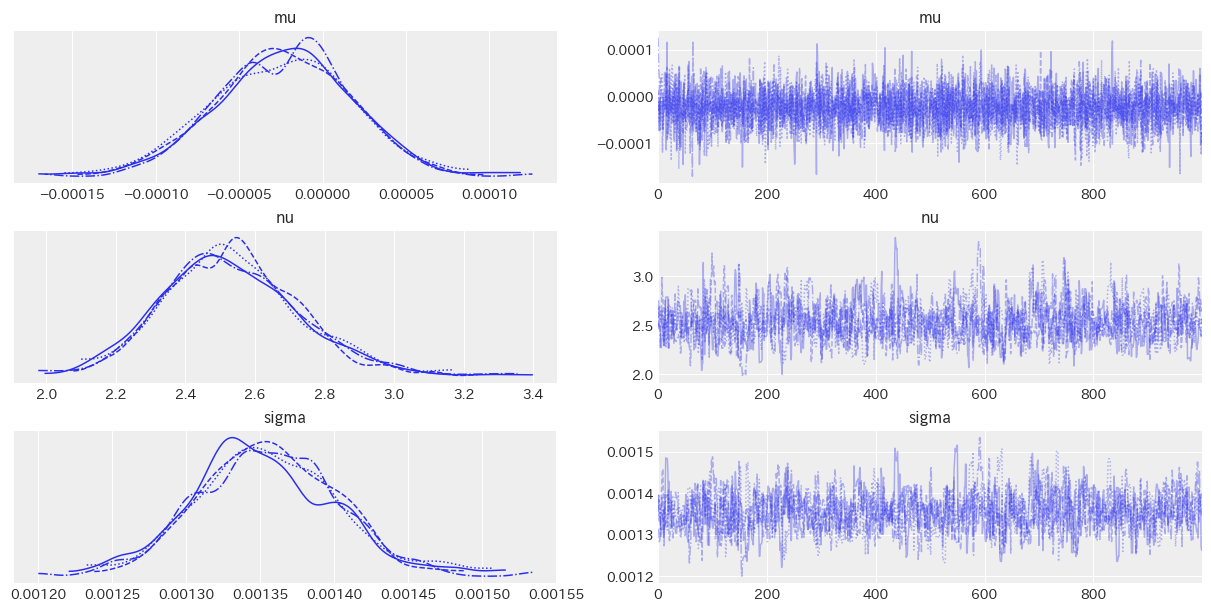

In [33]:
az.plot_trace(trace_t);

In [34]:
with nomura_bpi_t:
    pm.sample_posterior_predictive(trace_t, extend_inferencedata=True)

Sampling: [y_obs]


Output()

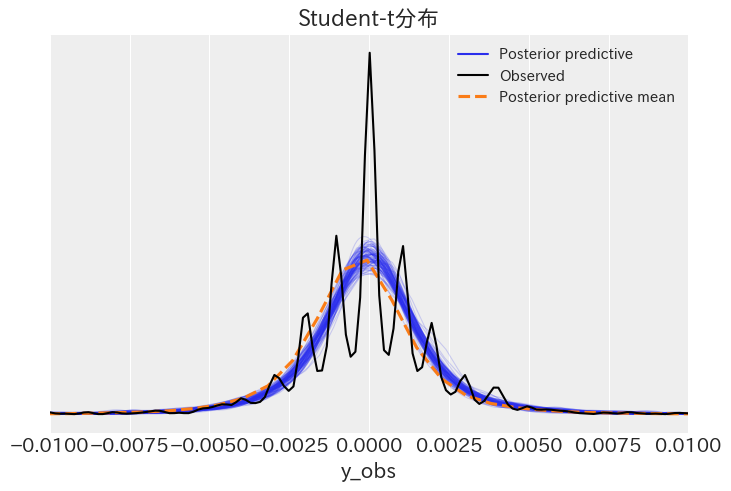

In [35]:
az.plot_ppc(trace_t, num_pp_samples=100)
plt.xlim(-0.01, 0.01)
plt.title('Student-t分布')
plt.show()

In [37]:
annualized_return = trace_t.posterior_predictive['y_obs'].values.flatten().mean() * 365.25
annualized_volatility = trace_t.posterior_predictive['y_obs'].values.flatten().std() * np.sqrt(365.25)
print(f'年率リターン: {annualized_return:.2%}')
print(f'年率ボラティリティ: {annualized_volatility:.2%}')

年率リターン: -0.88%
年率ボラティリティ: 6.00%
